# Support Vector Machine - 6 Hourly Taxi Demand Prediction

In this section we predict the 6-hourly demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

For that we proceed as follows:

- Build SVM model with different kernels to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best ones
- Build the model with found kernel and hyperparameters: make predictions for all spatial units
- Evaluation

<hr style="border: 1px solid #8888;">

In [8]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR
from sklearn import datasets

from scipy.stats import loguniform

import predictive as pred

In [9]:
# import datasets
df_6h_comar = pd.read_csv("data/datasets/df_6h_comar.csv")
df_6h_hexlow = pd.read_csv("data/datasets/df_6h_hexlow.csv")
df_6h_hexmed = pd.read_csv("data/datasets/df_6h_hexmed.csv")
df_6h_hexhig = pd.read_csv("data/datasets/df_6h_hexhig.csv")

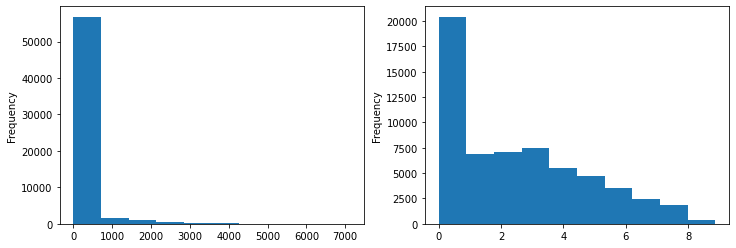

In [10]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_6h_comar['numOfTaxis_area'].plot.hist()

plt.subplot(122)
df_6h_comar['numOfTaxis_area'] = np.log(df_6h_comar['numOfTaxis_area'])
df_6h_comar['numOfTaxis_area'].plot.hist()
plt.show()

In [11]:
df_6h_comar.drop(columns = ['date_start'],inplace = True)
df_6h_hexlow.drop(columns = ['date_start'],inplace = True)
df_6h_hexmed.drop(columns = ['date_start'],inplace = True)
df_6h_hexhig.drop(columns = ['date_start'],inplace = True)

In [12]:
df_6h_comar = pred.dayandseas_to_int(df_6h_comar)
df_6h_hexlow = pred.dayandseas_to_int(df_6h_hexlow)
df_6h_hexmed = pred.dayandseas_to_int(df_6h_hexmed)
df_6h_hexhig = pred.dayandseas_to_int(df_6h_hexhig)

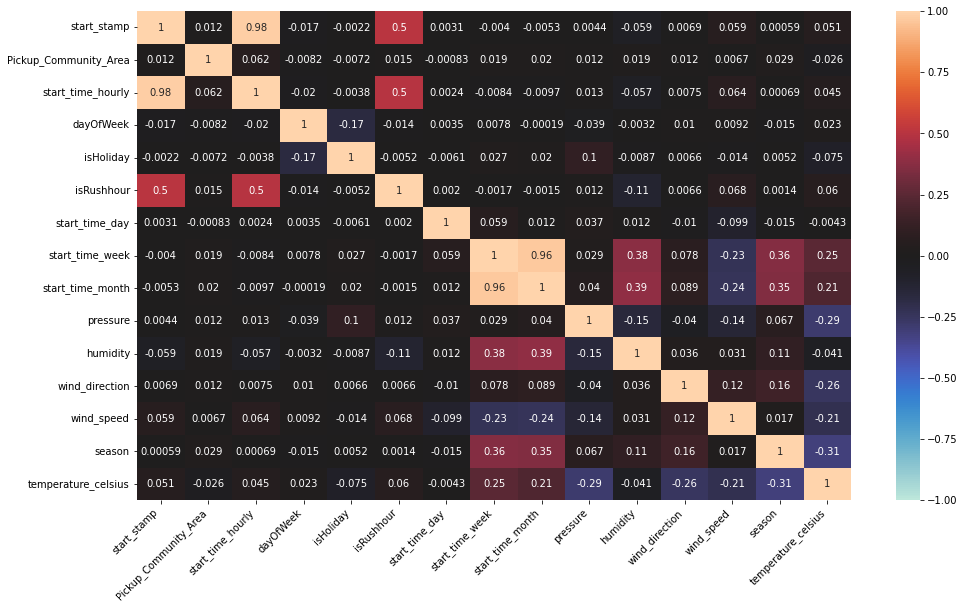

In [13]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_6h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. Also we observe a high correlation between `start_time_hourly` and `start_stamp`. So we are dropping `start_time_hourly`, because we are interested in the 6-hourly interval (which start is represented by `start_stamp`):

In [ ]:
df_24h_comar.drop(columns = ['start_time_month'],inplace = True)

In [ ]:
df_24h_comar.drop(columns = ['start_time_hourly'],inplace = True)

<hr style="border: 1px solid #8888;">

## 2 Hourly Demand - Community Area

In [5]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_comar,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [6]:
categoric, numeric = pred.cat_and_num('Pickup_Community_Area')

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [7]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000, max_iter=50000)

In [8]:
pipeline = pred.pipeline_fit_predict(svr_lin, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                               df_6h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -4416947.933596, rho = -44.484054
nSV = 40473, nBSV = 39149


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  92.479
MSE:  129830.214
RMSE:  360.320
Accuracy: 37.97 %
R2:  41.418 %
Max Residual Error:  6352.294


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [9]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000, max_iter=50000)

In [10]:
pipeline = pred.pipeline_fit_predict(svr_poly2, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                df_6h_comar, 'numOfTaxis_area')

[LibSVM]...........................*....*.*
optimization finished, #iter = 31955
obj = -5832941.724722, rho = -12.283446
nSV = 41466, nBSV = 40414
MODEL SCORES:
MAE:  138.201
MSE:  232015.185
RMSE:  481.680
Accuracy: 7.3 %
R2: -4.690 %
Max Residual Error:  7075.157


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [11]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000, max_iter=50000)

In [12]:
pipeline = pred.pipeline_fit_predict(svr_poly3, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                df_6h_comar, 'numOfTaxis_area')

[LibSVM]...........................*...*
optimization finished, #iter = 30561
obj = -5916403.601957, rho = -9.244729
nSV = 41613, nBSV = 39744
MODEL SCORES:
MAE:  141.549
MSE:  235699.529
RMSE:  485.489
Accuracy: 5.05 %
R2: -6.352 %
Max Residual Error:  7088.480


#### SVR KERNEL: RBF

In [13]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000, max_iter=50000)

In [15]:
pipeline = pred.pipeline_fit_predict(svr_rbf, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                df_6h_comar, 'numOfTaxis_area')

[LibSVM].........................*..*.*
optimization finished, #iter = 28178
obj = -5832691.441057, rho = -6.895119
nSV = 41457, nBSV = 39983
MODEL SCORES:
MAE:  138.109
MSE:  231989.134
RMSE:  481.653
Accuracy: 7.36 %
R2: -4.678 %
Max Residual Error:  7076.785


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

#### Sampling data for tuning:

In [16]:
x_val, y_val = pred.sampling_already_splitted(x_val, y_val, 'numOfTaxis_area', 5000)

In [17]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),        
                'model__epsilon':loguniform(1e-1, 1e2)}               

In [18]:
svr_lin = SVR(kernel = 'linear',cache_size=15000, max_iter=50000)

In [19]:
pipeline = pred.pipeline_for_prediction(categoric, numeric, svr_lin)

In [20]:
pred.find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-173.344 total time=   0.6s
[CV 2/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 2/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-147.733 total time=   0.6s
[CV 3/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 3/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-145.885 total time=   0.6s
[CV 4/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-145.475 total time=   0.6s
[CV 5/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 5/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-164.147 total time=   0.6s
[CV 6/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-173.400 total time=   0.6s
[CV 7/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 7/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-147.379 total time=   0.6s
[CV 8/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 8/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-146.488 total time=   0.6s
[CV 9/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 9/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-145.174 total time=   0.6s
[CV 10/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-164.092 total time=   0.6s
[CV 11/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 11/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-173.062 total time=   0.6s
[CV 12/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 12/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-147.881 total time=   0.6s
[CV 13/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-146.500 total time=   0.6s
[CV 14/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 14/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-145.243 total time=   0.6s
[CV 15/15; 1/50] START model__C=1.3292918943162166, model__epsilon=71.14476009343416
[CV 15/15; 1/50] END model__C=1.3292918943162166, model__epsilon=71.14476009343416;, score=-163.872 total time=   0.6s
[CV 1/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-97.532 total time=   1.1s
[CV 2/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-76.820 total time=   1.1s
[CV 3/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-76.344 total time=   1.1s
[CV 4/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-77.579 total time=   1.1s
[CV 5/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-91.569 total time=   1.1s
[CV 6/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-97.473 total time=   1.1s
[CV 7/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-75.288 total time=   1.1s
[CV 8/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-76.302 total time=   1.0s
[CV 9/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-78.953 total time=   1.0s
[CV 10/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-91.983 total time=   1.1s
[CV 11/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-96.071 total time=   1.1s
[CV 12/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-77.273 total time=   1.1s
[CV 13/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-78.101 total time=   1.1s
[CV 14/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-77.538 total time=   1.1s
[CV 15/15; 2/50] START model__C=15.702970884055382, model__epsilon=6.2513735745217485


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 2/50] END model__C=15.702970884055382, model__epsilon=6.2513735745217485;, score=-91.562 total time=   1.1s
[CV 1/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 1/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-152.265 total time=   1.2s
[CV 2/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 2/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-126.385 total time=   1.2s
[CV 3/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 3/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-124.954 total time=   1.2s
[CV 4/15; 3/50] START model__C=0.2938027938703535, model__epsilon=0.2937538457632829
[CV 4/15; 3/50] END model__C=0.2938027938703535, model__epsilon=0.2937538457632829;, score=-123.101 total time=   1.2s
[CV 5/15; 3/50] START model__C=0.2938027938703535, model__epsilon

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-112.165 total time=   0.7s
[CV 2/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-89.227 total time=   0.7s
[CV 3/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-88.384 total time=   0.8s
[CV 4/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-88.021 total time=   0.8s
[CV 5/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-104.548 total time=   0.7s
[CV 6/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-112.432 total time=   0.7s
[CV 7/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-88.197 total time=   0.7s
[CV 8/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-88.574 total time=   0.7s
[CV 9/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-88.517 total time=   0.7s
[CV 10/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-104.423 total time=   0.7s
[CV 11/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-111.458 total time=   0.7s
[CV 12/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-89.249 total time=   0.7s
[CV 13/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-89.645 total time=   0.7s
[CV 14/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-88.234 total time=   0.7s
[CV 15/15; 5/50] START model__C=6.358358856676251, model__epsilon=13.311216080736884


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 5/50] END model__C=6.358358856676251, model__epsilon=13.311216080736884;, score=-103.982 total time=   0.7s
[CV 1/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 1/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-191.769 total time=   0.5s
[CV 2/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 2/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-165.608 total time=   0.6s
[CV 3/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 3/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-164.186 total time=   0.6s
[CV 4/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.23245085588688
[CV 4/15; 6/50] END model__C=0.115279871282324, model__epsilon=81.23245085588688;, score=-163.096 total time=   0.6s
[CV 5/15; 6/50] START model__C=0.115279871282324, model__epsilon=81.2324508558868

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-88.155 total time=   2.5s
[CV 2/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-69.758 total time=   2.5s
[CV 3/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-68.717 total time=   2.5s
[CV 4/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-72.120 total time=   2.5s
[CV 5/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-84.690 total time=   2.5s
[CV 6/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-87.452 total time=   2.5s
[CV 7/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-67.545 total time=   2.5s
[CV 8/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-68.057 total time=   2.5s
[CV 9/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-74.038 total time=   2.5s
[CV 10/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-85.470 total time=   2.6s
[CV 11/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-85.632 total time=   2.5s
[CV 12/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-70.663 total time=   2.5s
[CV 13/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-69.843 total time=   2.5s
[CV 14/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-72.018 total time=   2.5s
[CV 15/15; 7/50] START model__C=31.428808908401084, model__epsilon=0.4335281794951565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 7/50] END model__C=31.428808908401084, model__epsilon=0.4335281794951565;, score=-85.399 total time=   2.5s
[CV 1/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 1/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-150.973 total time=   1.2s
[CV 2/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 2/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-125.048 total time=   1.2s
[CV 3/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 3/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-123.699 total time=   1.2s
[CV 4/15; 8/50] START model__C=0.3511356313970407, model__epsilon=0.35498788321965025
[CV 4/15; 8/50] END model__C=0.3511356313970407, model__epsilon=0.35498788321965025;, score=-121.858 total time=   1.2s
[CV 5/15; 8/50] START model__C=0.3511356313970407, model_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-129.255 total time=   1.3s
[CV 2/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-103.707 total time=   1.3s
[CV 3/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-102.511 total time=   1.4s
[CV 4/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-101.505 total time=   1.3s
[CV 5/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-120.434 total time=   1.3s
[CV 6/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-129.454 total time=   1.3s
[CV 7/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-103.529 total time=   1.3s
[CV 8/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-102.637 total time=   1.3s
[CV 9/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-100.864 total time=   1.3s
[CV 10/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-120.657 total time=   1.3s
[CV 11/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-129.362 total time=   1.3s
[CV 12/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-103.885 total time=   1.3s
[CV 13/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-103.285 total time=   1.3s
[CV 14/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-100.600 total time=   1.3s
[CV 15/15; 10/50] START model__C=1.976218934028007, model__epsilon=0.7476312062252299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 10/50] END model__C=1.976218934028007, model__epsilon=0.7476312062252299;, score=-120.198 total time=   1.3s
[CV 1/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-108.847 total time=   1.8s
[CV 2/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-85.676 total time=   1.7s
[CV 3/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-85.114 total time=   1.8s
[CV 4/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-84.878 total time=   1.7s
[CV 5/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-100.867 total time=   1.7s
[CV 6/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-108.654 total time=   1.8s
[CV 7/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-84.844 total time=   1.7s
[CV 8/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-85.122 total time=   1.7s
[CV 9/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-85.341 total time=   1.8s
[CV 10/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-101.419 total time=   1.8s
[CV 11/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-108.246 total time=   1.8s
[CV 12/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-85.785 total time=   1.7s
[CV 13/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-86.469 total time=   1.8s
[CV 14/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-84.712 total time=   1.7s
[CV 15/15; 11/50] START model__C=6.847920095574778, model__epsilon=0.262108787826544


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 11/50] END model__C=6.847920095574778, model__epsilon=0.262108787826544;, score=-100.273 total time=   1.7s
[CV 1/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 1/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-143.092 total time=   1.1s
[CV 2/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 2/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-117.252 total time=   1.1s
[CV 3/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 3/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-116.212 total time=   1.1s
[CV 4/15; 12/50] START model__C=0.7523742884534856, model__epsilon=1.2562773503807025
[CV 4/15; 12/50] END model__C=0.7523742884534856, model__epsilon=1.2562773503807025;, score=-114.488 total time=   1.1s
[CV 5/15; 12/50] START model__C=0.7523742884534856, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-106.681 total time=   0.7s
[CV 10/15; 13/50] START model__C=2.334586407601624, model__epsilon=22.673986523780385
[CV 10/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-126.178 total time=   0.7s
[CV 11/15; 13/50] START model__C=2.334586407601624, model__epsilon=22.673986523780385
[CV 11/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-134.714 total time=   0.7s
[CV 12/15; 13/50] START model__C=2.334586407601624, model__epsilon=22.673986523780385


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-109.812 total time=   0.7s
[CV 13/15; 13/50] START model__C=2.334586407601624, model__epsilon=22.673986523780385
[CV 13/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-108.799 total time=   0.7s
[CV 14/15; 13/50] START model__C=2.334586407601624, model__epsilon=22.673986523780385
[CV 14/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-107.048 total time=   0.7s
[CV 15/15; 13/50] START model__C=2.334586407601624, model__epsilon=22.673986523780385
[CV 15/15; 13/50] END model__C=2.334586407601624, model__epsilon=22.673986523780385;, score=-125.554 total time=   0.6s
[CV 1/15; 14/50] START model__C=0.3972110727381912, model__epsilon=3.4890188454913864
[CV 1/15; 14/50] END model__C=0.3972110727381912, model__epsilon=3.4890188454913864;, score=-150.198 total time=   1.0s
[CV 2/15; 14/50] START model__C=0.3972110727381912, mode

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-111.058 total time=   1.7s
[CV 2/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-87.561 total time=   1.7s
[CV 3/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-87.151 total time=   1.7s
[CV 4/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-86.588 total time=   1.7s
[CV 5/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-103.331 total time=   1.7s
[CV 6/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-111.015 total time=   1.7s
[CV 7/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-86.847 total time=   1.7s
[CV 8/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-86.880 total time=   1.7s
[CV 9/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-86.912 total time=   1.7s
[CV 10/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-103.351 total time=   1.7s
[CV 11/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-110.688 total time=   1.7s
[CV 12/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-87.983 total time=   1.7s
[CV 13/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-88.280 total time=   1.7s
[CV 14/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-86.353 total time=   1.7s
[CV 15/15; 15/50] START model__C=5.9874749104613985, model__epsilon=0.13783237455007183


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 15/50] END model__C=5.9874749104613985, model__epsilon=0.13783237455007183;, score=-102.818 total time=   1.7s
[CV 1/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-109.350 total time=   1.7s
[CV 2/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-86.315 total time=   1.7s
[CV 3/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-85.624 total time=   1.7s
[CV 4/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-85.414 total time=   1.7s
[CV 5/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-101.164 total time=   1.7s
[CV 6/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-109.110 total time=   1.7s
[CV 7/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-85.495 total time=   1.7s
[CV 8/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-85.566 total time=   1.7s
[CV 9/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-85.749 total time=   1.7s
[CV 10/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-101.775 total time=   1.7s
[CV 11/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-108.943 total time=   1.7s
[CV 12/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-86.436 total time=   1.7s
[CV 13/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-86.805 total time=   1.7s
[CV 14/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-85.298 total time=   1.7s
[CV 15/15; 16/50] START model__C=6.647135865318027, model__epsilon=0.32476735706274484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 16/50] END model__C=6.647135865318027, model__epsilon=0.32476735706274484;, score=-100.625 total time=   1.7s
[CV 1/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 1/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-185.042 total time=   0.6s
[CV 2/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 2/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-158.861 total time=   0.6s
[CV 3/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 3/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-157.441 total time=   0.6s
[CV 4/15; 17/50] START model__C=0.15673095467235415, model__epsilon=70.25166339242152
[CV 4/15; 17/50] END model__C=0.15673095467235415, model__epsilon=70.25166339242152;, score=-156.275 total time=   0.6s
[CV 5/15; 17/50] START model__C=0.15673095467235415, mo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-90.164 total time=   0.8s
[CV 2/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-72.312 total time=   0.8s
[CV 3/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-68.714 total time=   0.8s
[CV 4/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-74.352 total time=   0.8s
[CV 5/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-89.054 total time=   0.9s
[CV 6/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-89.677 total time=   0.8s
[CV 7/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-69.483 total time=   0.9s
[CV 8/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-68.546 total time=   0.9s
[CV 9/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-76.378 total time=   0.8s
[CV 10/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-88.134 total time=   0.9s
[CV 11/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-87.080 total time=   0.8s
[CV 12/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-72.285 total time=   0.8s
[CV 13/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-69.482 total time=   0.8s
[CV 14/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-74.754 total time=   0.8s
[CV 15/15; 18/50] START model__C=78.86714129990483, model__epsilon=26.619018884890558


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 18/50] END model__C=78.86714129990483, model__epsilon=26.619018884890558;, score=-89.022 total time=   0.8s
[CV 1/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 1/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-141.934 total time=   1.3s
[CV 2/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 2/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-116.042 total time=   1.3s
[CV 3/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 3/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-115.114 total time=   1.3s
[CV 4/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 4/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-113.425 total time=   1.3s
[CV 5/15; 19/50] START model__C=0.8200518402245829, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-116.184 total time=   1.3s
[CV 8/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 8/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-114.799 total time=   1.3s
[CV 9/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 9/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-113.184 total time=   1.3s
[CV 10/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 10/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-132.651 total time=   1.3s
[CV 11/15; 19/50] START model__C=0.8200518402245829, model__epsilon=0.1963434157293333
[CV 11/15; 19/50] END model__C=0.8200518402245829, model__epsilon=0.1963434157293333;, score=-142.187 total time=   1.3s
[CV 12/15; 19/50] START model__C=0.8200518402245829,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-102.068 total time=   1.4s
[CV 2/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-79.480 total time=   1.5s
[CV 3/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-79.887 total time=   1.5s
[CV 4/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-79.895 total time=   1.4s
[CV 5/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-94.494 total time=   1.5s
[CV 6/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-101.563 total time=   1.5s
[CV 7/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-78.606 total time=   1.4s
[CV 8/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-79.539 total time=   1.5s
[CV 9/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-80.830 total time=   1.5s
[CV 10/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-94.526 total time=   1.5s
[CV 11/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-100.650 total time=   1.4s
[CV 12/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-80.188 total time=   1.4s
[CV 13/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-81.459 total time=   1.4s
[CV 14/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-79.379 total time=   1.4s
[CV 15/15; 20/50] START model__C=11.290133559092672, model__epsilon=2.0914981329035602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 20/50] END model__C=11.290133559092672, model__epsilon=2.0914981329035602;, score=-94.282 total time=   1.5s
[CV 1/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 1/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-153.992 total time=   1.0s
[CV 2/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 2/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-128.136 total time=   1.0s
[CV 3/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 3/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-126.706 total time=   1.0s
[CV 4/15; 21/50] START model__C=0.2323350351539011, model__epsilon=3.0586566669785253
[CV 4/15; 21/50] END model__C=0.2323350351539011, model__epsilon=3.0586566669785253;, score=-124.885 total time=   1.0s
[CV 5/15; 21/50] START model__C=0.2323350351539011, mode

[CV 10/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-138.586 total time=   0.8s
[CV 11/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 11/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-148.211 total time=   0.8s
[CV 12/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 12/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-122.027 total time=   0.8s
[CV 13/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 13/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-121.126 total time=   0.9s
[CV 14/15; 23/50] START model__C=0.5975027999960293, model__epsilon=9.717775305059629
[CV 14/15; 23/50] END model__C=0.5975027999960293, model__epsilon=9.717775305059629;, score=-119.098 total time=   0.8s
[CV 15/15; 23/50] START model__C=0.5975027999960293, mod

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-116.156 total time=   1.6s
[CV 2/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-91.718 total time=   1.5s
[CV 3/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-91.126 total time=   1.6s
[CV 4/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-90.162 total time=   1.6s
[CV 5/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-108.472 total time=   1.6s
[CV 6/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-116.548 total time=   1.6s
[CV 7/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-91.218 total time=   1.6s
[CV 8/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-91.120 total time=   1.6s
[CV 9/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-90.019 total time=   1.6s
[CV 10/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-108.928 total time=   1.6s
[CV 11/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-115.955 total time=   1.6s
[CV 12/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-91.959 total time=   1.5s
[CV 13/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-92.137 total time=   1.6s
[CV 14/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-89.769 total time=   1.6s
[CV 15/15; 25/50] START model__C=4.366473592979633, model__epsilon=0.35856126103453967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 25/50] END model__C=4.366473592979633, model__epsilon=0.35856126103453967;, score=-108.062 total time=   1.6s
[CV 1/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-88.719 total time=   1.0s
[CV 2/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-71.059 total time=   1.0s
[CV 3/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-67.278 total time=   1.0s
[CV 4/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-72.884 total time=   1.0s
[CV 5/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-87.643 total time=   0.9s
[CV 6/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-88.336 total time=   0.9s
[CV 7/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-68.335 total time=   1.0s
[CV 8/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-66.950 total time=   1.0s
[CV 9/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-75.150 total time=   1.0s
[CV 10/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-86.632 total time=   1.0s
[CV 11/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-85.648 total time=   0.9s
[CV 12/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-71.143 total time=   1.0s
[CV 13/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-68.306 total time=   1.0s
[CV 14/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-73.225 total time=   1.0s
[CV 15/15; 26/50] START model__C=81.05016126411583, model__epsilon=21.154290797261208


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 26/50] END model__C=81.05016126411583, model__epsilon=21.154290797261208;, score=-87.822 total time=   1.0s
[CV 1/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-95.832 total time=   0.6s
[CV 2/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-78.591 total time=   0.6s
[CV 3/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-75.530 total time=   0.6s
[CV 4/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-79.924 total time=   0.6s
[CV 5/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-95.278 total time=   0.6s
[CV 6/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-95.963 total time=   0.6s
[CV 7/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-75.798 total time=   0.6s
[CV 8/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-75.343 total time=   0.6s
[CV 9/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-83.138 total time=   0.6s
[CV 10/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-94.164 total time=   0.6s
[CV 11/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-92.970 total time=   0.6s
[CV 12/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-77.874 total time=   0.6s
[CV 13/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-76.167 total time=   0.6s
[CV 14/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-80.858 total time=   0.6s
[CV 15/15; 27/50] START model__C=65.84106160121607, model__epsilon=48.35952776465949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 27/50] END model__C=65.84106160121607, model__epsilon=48.35952776465949;, score=-95.103 total time=   0.6s
[CV 1/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-139.081 total time=   0.5s
[CV 2/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 2/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-114.196 total time=   0.5s
[CV 3/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-113.249 total time=   0.5s
[CV 4/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 4/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-115.269 total time=   0.5s
[CV 5/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 5/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-129.594 total time=   0.5s
[CV 6/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 6/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-138.055 total time=   0.5s
[CV 7/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-113.660 total time=   0.5s
[CV 8/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-114.340 total time=   0.5s
[CV 9/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-115.580 total time=   0.5s
[CV 10/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 10/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-129.690 total time=   0.5s
[CV 11/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-136.571 total time=   0.5s
[CV 12/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-116.735 total time=   0.5s
[CV 13/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 13/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-115.081 total time=   0.5s
[CV 14/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-114.688 total time=   0.5s
[CV 15/15; 28/50] START model__C=6.218704727769076, model__epsilon=58.293845429947346
[CV 15/15; 28/50] END model__C=6.218704727769076, model__epsilon=58.293845429947346;, score=-128.640 total time=   0.5s
[CV 1/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 1/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-155.057 total time=   1.2s
[CV 2/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 2/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-129.179 total time=   1.2s
[CV 3/15; 29/50] START model__C=0.18427970406864538, model__epsilon=0.3872118032174582
[CV 3/15; 29/50] END model__C=0.18427970406864538, model__epsilon=0.3872118032174582;, score=-127.647 total time=   1.2s
[CV 4/15; 29/50] START model__C=0.1842797040686453

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-133.911 total time=   1.3s
[CV 2/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-108.245 total time=   1.3s
[CV 3/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-107.060 total time=   1.3s
[CV 4/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-105.600 total time=   1.3s
[CV 5/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-124.749 total time=   1.3s
[CV 6/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-134.188 total time=   1.3s
[CV 7/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-108.207 total time=   1.3s
[CV 8/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-106.962 total time=   1.3s
[CV 9/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-105.317 total time=   1.3s
[CV 10/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-124.989 total time=   1.3s
[CV 11/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-134.178 total time=   1.3s
[CV 12/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-108.186 total time=   1.3s
[CV 13/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-107.525 total time=   1.3s
[CV 14/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-105.061 total time=   1.3s
[CV 15/15; 31/50] START model__C=1.4656553886225332, model__epsilon=0.6516990611177174


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 31/50] END model__C=1.4656553886225332, model__epsilon=0.6516990611177174;, score=-124.419 total time=   1.3s
[CV 1/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-88.251 total time=   2.2s
[CV 2/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-69.859 total time=   2.2s
[CV 3/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-68.799 total time=   2.2s
[CV 4/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-72.139 total time=   2.2s
[CV 5/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-84.908 total time=   2.3s
[CV 6/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-87.557 total time=   2.2s
[CV 7/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-67.603 total time=   2.2s
[CV 8/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-68.157 total time=   2.2s
[CV 9/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-74.087 total time=   2.2s
[CV 10/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-85.807 total time=   2.2s
[CV 11/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-85.921 total time=   2.2s
[CV 12/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-70.721 total time=   2.2s
[CV 13/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-70.354 total time=   2.2s
[CV 14/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-72.105 total time=   2.2s
[CV 15/15; 32/50] START model__C=30.634622106220824, model__epsilon=1.1756010900231848


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 32/50] END model__C=30.634622106220824, model__epsilon=1.1756010900231848;, score=-85.562 total time=   2.2s
[CV 1/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 1/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-144.396 total time=   0.9s
[CV 2/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 2/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-118.586 total time=   1.0s
[CV 3/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 3/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-117.455 total time=   0.9s
[CV 4/15; 33/50] START model__C=0.6963114377829286, model__epsilon=4.247058562261868
[CV 4/15; 33/50] END model__C=0.6963114377829286, model__epsilon=4.247058562261868;, score=-115.942 total time=   0.9s
[CV 5/15; 33/50] START model__C=0.6963114377829286, model__epsil

[CV 10/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-187.243 total time=   0.5s
[CV 11/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 11/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-197.115 total time=   0.5s
[CV 12/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 12/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-171.095 total time=   0.5s
[CV 13/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 13/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-169.725 total time=   0.5s
[CV 14/15; 35/50] START model__C=0.16736010167825777, model__epsilon=91.33995846860967
[CV 14/15; 35/50] END model__C=0.16736010167825777, model__epsilon=91.33995846860967;, score=-168.537 total time=   0.5s
[CV 15/15; 35/50] START model__C=0.167360101678

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-93.472 total time=   2.3s
[CV 2/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-73.017 total time=   2.3s
[CV 3/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-73.362 total time=   2.3s
[CV 4/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-75.180 total time=   2.2s
[CV 5/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-87.701 total time=   2.2s
[CV 6/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-92.355 total time=   2.3s
[CV 7/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-71.678 total time=   2.3s
[CV 8/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-72.910 total time=   2.3s
[CV 9/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-76.443 total time=   2.3s
[CV 10/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-88.275 total time=   2.3s
[CV 11/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-91.435 total time=   2.3s
[CV 12/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-73.903 total time=   2.3s
[CV 13/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-74.592 total time=   2.2s
[CV 14/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-74.785 total time=   2.3s
[CV 15/15; 36/50] START model__C=20.73644517790503, model__epsilon=0.39459088111


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 36/50] END model__C=20.73644517790503, model__epsilon=0.39459088111;, score=-88.117 total time=   2.3s
[CV 1/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 1/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-164.996 total time=   0.7s
[CV 2/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 2/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-139.062 total time=   0.7s
[CV 3/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 3/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-137.516 total time=   0.7s
[CV 4/15; 37/50] START model__C=0.10388823104027935, model__epsilon=27.95015916508335
[CV 4/15; 37/50] END model__C=0.10388823104027935, model__epsilon=27.95015916508335;, score=-135.976 total time=   0.7s
[CV 5/15; 37/50] START model__C=0.10388823104027935, model__ep

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-102.103 total time=   0.7s
[CV 2/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-80.511 total time=   0.8s
[CV 3/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-80.278 total time=   0.8s
[CV 4/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-80.784 total time=   0.8s
[CV 5/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-95.271 total time=   0.8s
[CV 6/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-102.046 total time=   0.8s
[CV 7/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-78.990 total time=   0.7s
[CV 8/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-80.311 total time=   0.7s
[CV 9/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-82.121 total time=   0.8s
[CV 10/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-95.236 total time=   0.7s
[CV 11/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-100.616 total time=   0.7s
[CV 12/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-80.612 total time=   0.8s
[CV 13/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-82.128 total time=   0.7s
[CV 14/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-81.027 total time=   0.8s
[CV 15/15; 38/50] START model__C=13.199942261535016, model__epsilon=15.382308040278993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 38/50] END model__C=13.199942261535016, model__epsilon=15.382308040278993;, score=-95.166 total time=   0.7s
[CV 1/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-93.482 total time=   2.4s
[CV 2/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-73.126 total time=   2.3s
[CV 3/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-73.339 total time=   2.4s
[CV 4/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-75.257 total time=   2.3s
[CV 5/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-87.689 total time=   2.4s
[CV 6/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-92.444 total time=   2.4s
[CV 7/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-71.776 total time=   2.3s
[CV 8/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-72.919 total time=   2.4s
[CV 9/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-76.520 total time=   2.3s
[CV 10/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-88.337 total time=   2.4s
[CV 11/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-91.444 total time=   2.4s
[CV 12/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-73.978 total time=   2.3s
[CV 13/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-74.612 total time=   2.4s
[CV 14/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-74.869 total time=   2.4s
[CV 15/15; 39/50] START model__C=20.59733535743719, model__epsilon=0.16677615430197912


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 39/50] END model__C=20.59733535743719, model__epsilon=0.16677615430197912;, score=-88.116 total time=   2.4s
[CV 1/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-136.949 total time=   1.4s
[CV 2/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-111.066 total time=   1.3s
[CV 3/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 3/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-110.149 total time=   1.3s
[CV 4/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-108.687 total time=   1.3s
[CV 5/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-127.644 total time=   1.3s
[CV 6/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-137.248 total time=   1.4s
[CV 7/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-111.252 total time=   1.3s
[CV 8/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-109.931 total time=   1.3s
[CV 9/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-108.496 total time=   1.3s
[CV 10/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-128.015 total time=   1.3s
[CV 11/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-137.179 total time=   1.4s
[CV 12/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677
[CV 12/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-111.169 total time=   1.4s
[CV 13/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-110.558 total time=   1.4s
[CV 14/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-108.085 total time=   1.3s
[CV 15/15; 40/50] START model__C=1.1895896737553546, model__epsilon=0.22264204303769677


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 40/50] END model__C=1.1895896737553546, model__epsilon=0.22264204303769677;, score=-127.316 total time=   1.3s
[CV 1/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-87.737 total time=   1.3s
[CV 2/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-69.428 total time=   1.2s
[CV 3/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-68.612 total time=   1.2s
[CV 4/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-71.623 total time=   1.3s
[CV 5/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-85.254 total time=   1.3s
[CV 6/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-87.444 total time=   1.3s
[CV 7/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-67.238 total time=   1.3s
[CV 8/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-68.076 total time=   1.2s
[CV 9/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-73.586 total time=   1.3s
[CV 10/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-85.448 total time=   1.3s
[CV 11/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-85.235 total time=   1.3s
[CV 12/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-70.059 total time=   1.2s
[CV 13/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-69.793 total time=   1.2s
[CV 14/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-71.606 total time=   1.2s
[CV 15/15; 41/50] START model__C=38.8427775470314, model__epsilon=7.41129978108324


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 41/50] END model__C=38.8427775470314, model__epsilon=7.41129978108324;, score=-85.931 total time=   1.2s
[CV 1/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-139.693 total time=   1.3s
[CV 2/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 2/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-113.665 total time=   1.3s
[CV 3/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-112.917 total time=   1.3s
[CV 4/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 4/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-111.325 total time=   1.3s
[CV 5/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 5/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-130.316 total time=   1.3s
[CV 6/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 6/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-139.938 total time=   1.3s
[CV 7/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-113.854 total time=   1.3s
[CV 8/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-112.689 total time=   1.3s
[CV 9/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-111.080 total time=   1.3s
[CV 10/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 10/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-130.558 total time=   1.3s
[CV 11/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-139.904 total time=   1.3s
[CV 12/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-113.763 total time=   1.3s
[CV 13/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 13/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-113.083 total time=   1.3s
[CV 14/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748
[CV 14/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-110.834 total time=   1.3s
[CV 15/15; 42/50] START model__C=0.9833181933644887, model__epsilon=0.15512259126484748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 42/50] END model__C=0.9833181933644887, model__epsilon=0.15512259126484748;, score=-130.093 total time=   1.3s
[CV 1/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 1/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-141.450 total time=   1.2s
[CV 2/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 2/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-115.462 total time=   1.2s
[CV 3/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 3/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-114.635 total time=   1.2s
[CV 4/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 4/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-112.979 total time=   1.2s
[CV 5/15; 43/50] START model__C=0.8569331925053982, mo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-141.759 total time=   1.2s
[CV 12/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 12/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-115.522 total time=   1.2s
[CV 13/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 13/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-114.808 total time=   1.2s
[CV 14/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 14/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-112.527 total time=   1.2s
[CV 15/15; 43/50] START model__C=0.8569331925053982, model__epsilon=0.9452571391072306
[CV 15/15; 43/50] END model__C=0.8569331925053982, model__epsilon=0.9452571391072306;, score=-131.802 total time=   1.2s
[CV 1/15; 44/50] START model__C=15.446089075047

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-98.206 total time=   0.9s
[CV 2/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-77.329 total time=   1.0s
[CV 3/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-77.016 total time=   1.0s
[CV 4/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-78.019 total time=   0.9s
[CV 5/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-92.061 total time=   0.9s
[CV 6/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-97.830 total time=   1.0s
[CV 7/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-75.775 total time=   1.0s
[CV 8/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-76.969 total time=   0.9s
[CV 9/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-79.332 total time=   0.9s
[CV 10/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-92.333 total time=   1.0s
[CV 11/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-96.456 total time=   1.0s
[CV 12/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-77.682 total time=   1.0s
[CV 13/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-78.617 total time=   1.0s
[CV 14/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-77.988 total time=   1.0s
[CV 15/15; 44/50] START model__C=15.446089075047073, model__epsilon=8.178476574339538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 44/50] END model__C=15.446089075047073, model__epsilon=8.178476574339538;, score=-92.073 total time=   1.0s
[CV 1/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-86.515 total time=   2.0s
[CV 2/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-68.261 total time=   2.0s
[CV 3/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-66.105 total time=   2.0s
[CV 4/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-70.665 total time=   2.0s
[CV 5/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-83.821 total time=   2.0s
[CV 6/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-85.975 total time=   2.0s
[CV 7/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-65.713 total time=   2.0s
[CV 8/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-65.408 total time=   2.0s
[CV 9/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-72.731 total time=   2.0s
[CV 10/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-84.316 total time=   2.0s
[CV 11/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-84.116 total time=   2.0s
[CV 12/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-69.132 total time=   2.0s
[CV 13/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-67.554 total time=   2.0s
[CV 14/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-70.577 total time=   2.0s
[CV 15/15; 45/50] START model__C=45.88156549160973, model__epsilon=2.610025650613476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 45/50] END model__C=45.88156549160973, model__epsilon=2.610025650613476;, score=-84.668 total time=   2.0s
[CV 1/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 1/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-156.914 total time=   0.8s
[CV 2/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 2/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-131.002 total time=   0.8s
[CV 3/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 3/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-129.680 total time=   0.8s
[CV 4/15; 46/50] START model__C=0.22844556850020528, model__epsilon=13.795402040204177
[CV 4/15; 46/50] END model__C=0.22844556850020528, model__epsilon=13.795402040204177;, score=-128.089 total time=   0.8s
[CV 5/15; 46/50] START model__C=0.2284455685002052

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-94.657 total time=   1.2s
[CV 2/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-74.762 total time=   1.2s
[CV 3/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-74.308 total time=   1.2s
[CV 4/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-76.504 total time=   1.2s
[CV 5/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-89.152 total time=   1.2s
[CV 6/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-93.698 total time=   1.2s
[CV 7/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-73.352 total time=   1.2s
[CV 8/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-74.050 total time=   1.2s
[CV 9/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-77.809 total time=   1.2s
[CV 10/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-89.619 total time=   1.2s
[CV 11/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-92.743 total time=   1.2s
[CV 12/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-75.407 total time=   1.2s
[CV 13/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-75.806 total time=   1.2s
[CV 14/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-76.229 total time=   1.2s
[CV 15/15; 47/50] START model__C=19.158219548093165, model__epsilon=4.8287152161792095


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 47/50] END model__C=19.158219548093165, model__epsilon=4.8287152161792095;, score=-89.339 total time=   1.2s
[CV 1/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-93.629 total time=   1.5s
[CV 2/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-73.457 total time=   1.5s
[CV 3/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-73.478 total time=   1.5s
[CV 4/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-75.488 total time=   1.5s
[CV 5/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-87.922 total time=   1.5s
[CV 6/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-92.813 total time=   1.5s
[CV 7/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-72.006 total time=   1.5s
[CV 8/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-73.169 total time=   1.5s
[CV 9/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-76.713 total time=   1.5s
[CV 10/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-88.643 total time=   1.5s
[CV 11/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-91.656 total time=   1.5s
[CV 12/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-74.215 total time=   1.5s
[CV 13/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-74.934 total time=   1.5s
[CV 14/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-75.150 total time=   1.5s
[CV 15/15; 48/50] START model__C=20.55424552015074, model__epsilon=3.0296104428212476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 48/50] END model__C=20.55424552015074, model__epsilon=3.0296104428212476;, score=-88.322 total time=   1.5s
[CV 1/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-119.052 total time=   1.2s
[CV 2/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-94.657 total time=   1.2s
[CV 3/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-93.411 total time=   1.2s
[CV 4/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-92.660 total time=   1.2s
[CV 5/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-111.065 total time=   1.2s
[CV 6/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-119.747 total time=   1.2s
[CV 7/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-94.146 total time=   1.2s
[CV 8/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-93.725 total time=   1.2s
[CV 9/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-92.222 total time=   1.2s
[CV 10/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-111.186 total time=   1.2s
[CV 11/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-119.371 total time=   1.2s
[CV 12/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-94.800 total time=   1.2s
[CV 13/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-94.360 total time=   1.2s
[CV 14/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-92.405 total time=   1.2s
[CV 15/15; 49/50] START model__C=3.699972431463808, model__epsilon=1.9170041589170652


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 49/50] END model__C=3.699972431463808, model__epsilon=1.9170041589170652;, score=-110.444 total time=   1.2s
[CV 1/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 1/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-157.062 total time=   1.2s
[CV 2/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 2/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-131.203 total time=   1.3s
[CV 3/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 3/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-129.641 total time=   1.2s
[CV 4/15; 50/50] START model__C=0.11919481947918735, model__epsilon=0.21070472806578233
[CV 4/15; 50/50] END model__C=0.11919481947918735, model__epsilon=0.21070472806578233;, score=-127.807 total time=   1.2s
[CV 5/15; 50/50] START model__C=0.119194

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [21]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 2.610025650613476, C= 45.88156549160973,verbose = 10)

In [22]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                     df_6h_comar, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -99358409.231279, rho = -67.651938
nSV = 19266, nBSV = 13922


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  74.799
MSE:  70419.862
RMSE:  265.367
Accuracy: 49.83 %
R2:  68.225 %
Max Residual Error:  5277.985


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon low resolution 

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_hexlow,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_low_res')

In [60]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [61]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train_val, y_train_val, x_test, y_test,
                                      df_6h_hexlow, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -106216334.908176, rho = -31.404760
nSV = 45998, nBSV = 34352


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  49.649
MSE:  19335.192
RMSE:  139.051
Accuracy: 42.61 %
R2:  59.394 %
Max Residual Error:  1997.387


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon medium resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_hexmed,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_medium_res')

In [72]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [73]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_6h_hexmed, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -71769692.922822, rho = -9.900635
nSV = 53540, nBSV = 36094


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  21.106
MSE:  3232.545
RMSE:  56.855
Accuracy: 34.96 %
R2:  60.551 %
Max Residual Error:  1298.962


<hr style="border: 0.5px solid #8888;">


## Hourly Demand - hexagon high resolution

In [ ]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_6h_hexhig,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [ ]:
categoric, numeric = pred.cat_and_num('h3_hex_id_high_res')

In [78]:
svr_lin_daily = SVR(kernel = 'linear',cache_size=15000, max_iter=50000,epsilon = 0.4335281794951565, C= 31.428808908401084, verbose =10)

In [79]:
pipeline = pred.pipeline_fit_predict(svr_lin_daily, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_6h_hexhig, 'numOfTaxis_area')

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -54172541.831035, rho = -1.700378
nSV = 59016, nBSV = 39918


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.751
MSE:  628.844
RMSE:  25.077
Accuracy: 16.63 %
R2:  45.458 %
Max Residual Error:  599.243
